# CS696: Project
**Members:**
* Dwayne Wilkes (RedID: 821789391)
* Manav Sanghavi (RedID: 822549761)

Formula 1 is a global motorsport with hundreds of millions of fans watching drivers race in the fastest four wheeled cars in the world. F1 has becoming a very data intensive sport, with teams collecting terabytes of performance metrics and data every race weekend.

In this project we use the F1 dataset available [here](https://www.kaggle.com/cjgdev/formula-1-race-data-19502017) to predict who would win the race after a given percentage of the race is completed.
We also used the data to plot a few more interesting graphs, which are described in the following sections.

## Using the notebook
A lot of the graphs rely on variables to decide what data to use. These variables can be changed to view data on different races, different seasons, and so on!

**Note:** As the dataset has data over almost 7 decades worth of races, there can be outliers where the output may be odd or the graphs may fail.

## Setting up

In [1]:
DATA_DIR = './f1-data'

In [2]:
import pandas as pd
import sklearn.linear_model
import sklearn.svm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
import os
import json
import math

from datetime import datetime
from html.parser import HTMLParser
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

In [3]:
def plot_large():
    plt.figure(figsize=(8, 5), dpi=200)

sns.set()

In [4]:
races = pd.read_csv(os.path.join(DATA_DIR, 'races.csv'))
constructors = pd.read_csv(os.path.join(DATA_DIR, 'constructors.csv'))
constructor_standings = pd.read_csv(os.path.join(DATA_DIR, 'constructorStandings.csv')).drop(columns=['Unnamed: 7'])
results = pd.read_csv(os.path.join(DATA_DIR, 'results.csv'))
circuits = pd.read_csv(os.path.join(DATA_DIR, 'circuits.csv'), encoding='ISO-8859-1')
lap_times = pd.read_csv(os.path.join(DATA_DIR, 'lapTimes.csv'))
drivers = pd.read_csv(os.path.join(DATA_DIR, 'drivers.csv'), encoding='ISO-8859-1')

## Race Predictions
Using a grid search on an SVR we can predict the race winner at different stages of the race. The preset values given below show the predictions for the 2011 European Grand Prix. The variables can be changed to different race ids to get predictions for different races, and the `race_percent` and `range_c` variables change the search space for the grid search.

**Important Note**: The dataset only contains lap times from 1990 to 2017. Using a `race_id` value for a race outside of these years will fail.

In [5]:
race_id = 848
race_percent = [0.2, 0.4, 0.6, 0.8]
range_c = range(25, 1000, 25)

### Setting up the data
We first get the lap times for the drivers in the given `race_id`. We also get the mapping to find which driver has what driverId and store it in `race_drivers`.

In [6]:
driver_times = lap_times.groupby([lap_times.raceId, lap_times.driverId, lap_times.lap]).sum().reset_index()
race_drivers = results[results.raceId == race_id][['driverId']]
race_drivers = race_drivers.set_index('driverId').join(drivers.set_index('driverId'))
race_drivers = race_drivers.reset_index()[['driverId', 'driverRef']]
race_drivers = race_drivers.set_index('driverId').to_dict()['driverRef']

### Predictions
In `create_and_score`, we use the given `c` and `percent` values to create an SVR model. We are only using the RBF kernel with `gamma` set to `scale` as other kernels and gamma values give poor results.

Lap times of every driver up to the `percent` of the race are given to the model as training input, with the milliseconds being given as labels. The last lap's milliseconds are then predicted using the trained classifier. This is repeated for every driver.

Scoring is done by calculating how many positions off was the prediction. So for example, if Driver A finished in 1st place but our prediction says he finished in 2nd place, then the error is 1; if the prediction was to finish in 3rd place, then the error is 2; and so forth. A correct prediction results in 0 error. The errors for every driver are added up to get the total error for a given `c` at a given `percent` of the race.

In [7]:
def create_and_score(c, percent):
    total_laps = results[results.raceId == race_id].laps.max()
    training_laps = math.floor(total_laps * percent)
    classifier = sklearn.svm.SVR(kernel="rbf", C=c, gamma='scale')
    race_predictions = {'driver': [], 'milliseconds': []}
    for driver in race_drivers.keys():
        X = driver_times[(driver_times.raceId == race_id) & (driver_times.driverId == driver)]
        X_train = X[X.lap.isin(range(1, training_laps))]['lap'].values.reshape(-1, 1)
        y_train = X[X.lap.isin(range(1, training_laps))]['milliseconds']
        X_test = X[X.lap.isin(range(training_laps, total_laps))]['lap'].values.reshape(-1, 1)

        if len(X_test) <= total_laps - training_laps - 3:
            continue

        classifier.fit(X_train, y_train)
        race_predictions['driver'].append(driver)
        race_predictions['milliseconds'].append(classifier.predict(X_test[-1].reshape(-1, 1))[0])

    def custom_scorer_function():
        predictions_df = pd.DataFrame(race_predictions)
        predictions_df = predictions_df.sort_values(by='milliseconds')
        results_df = results[results.raceId == race_id].sort_values('position')
        scoring_df = {'driver_pred': [], 'driver_true': [], 'error': []}
        
        for driver in predictions_df.driver:
            prediction = predictions_df[predictions_df.driver == driver].index[0]
            prediction = predictions_df.index.get_loc(prediction) + 1
            driver_true = results_df[results_df.driverId == driver].position.values[0]
            error = abs(prediction - driver_true)
            
            try:
                scoring_df['driver_true'].append(results_df.iloc[prediction-1].driverId)
                scoring_df['driver_pred'].append(driver)
                scoring_df['error'].append(error)
            except:
                continue
        scoring_df = pd.DataFrame(scoring_df)
        return scoring_df

    scoring_df = custom_scorer_function()
    return (classifier, scoring_df)

### Running the grid search
Now we can train models on the given range of parameters and collect statistics. Once all the models are trained, we plot their results. A lower error rate means a better parameter combination.

Scoring model at 20.0% of the race, C-value progress:
25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, DONE!!!
Scoring model at 40.0% of the race, C-value progress:
25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, DONE!!!
Scoring model at 60.0% of the race, C-value progress:
25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, DONE!!!
Scoring model at 80.0% of the race, C-value progress:
25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 95

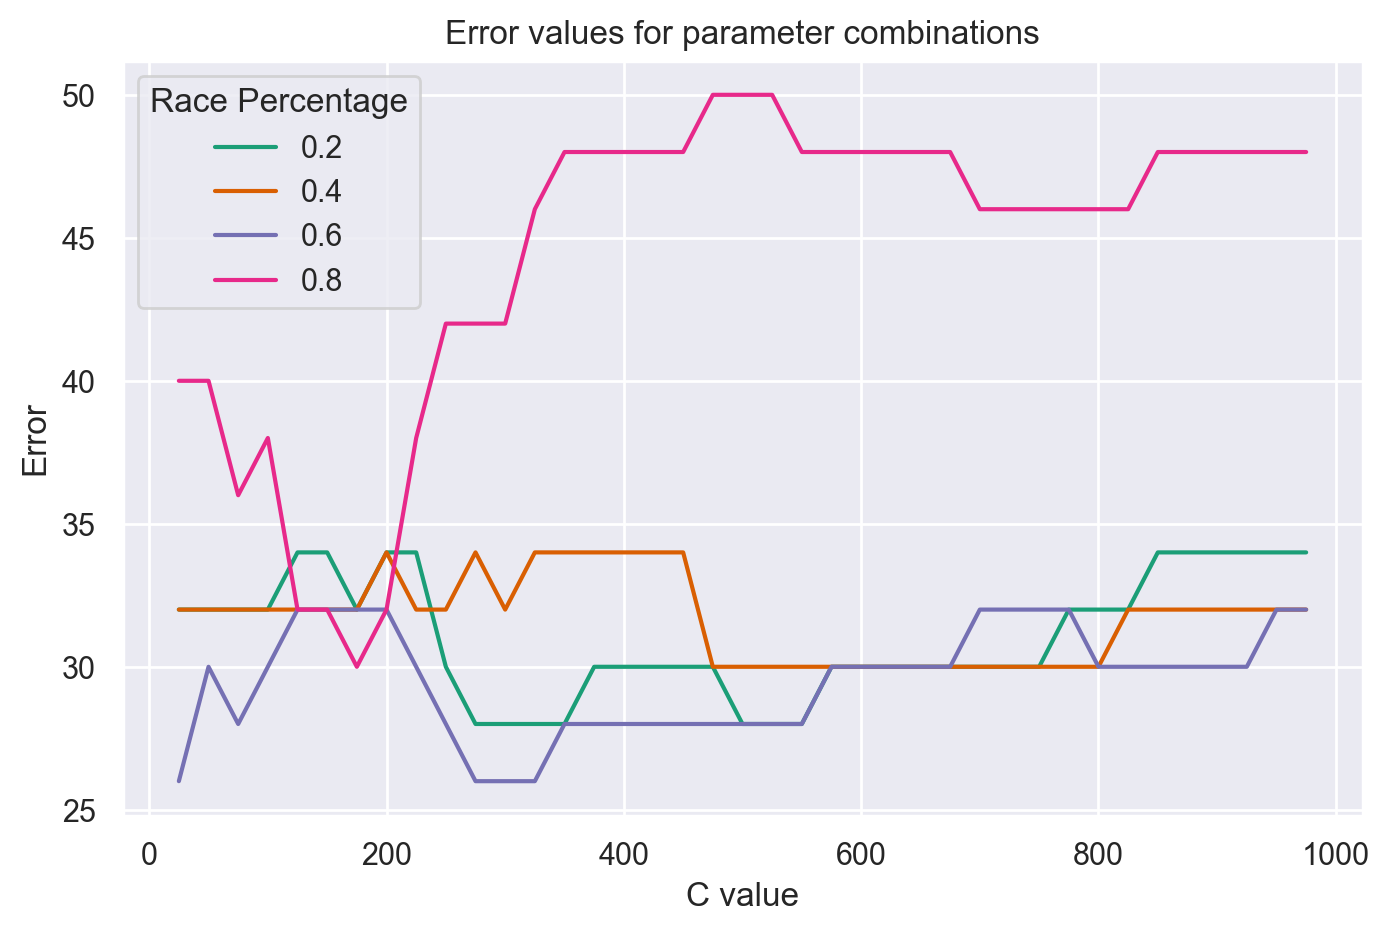

In [8]:
error_dict = {'c': [], 'error': [], 'race_percent': []}
for percent in race_percent:
    print("Scoring model at {}% of the race, C-value progress:".format(percent*100))
    for c in range_c:
        print("{},".format(c), end=" ")
        classifier, scoring_df = create_and_score(c, percent)
        error_dict['error'].append(scoring_df.error.sum())
        error_dict['c'].append(c)
        error_dict['race_percent'].append(str(percent))
    print('DONE!!!')

plot_large()
sns.lineplot(x=error_dict['c'], y=error_dict['error'], hue=error_dict['race_percent'],
            palette=sns.color_palette('Dark2', len(race_percent)))
plt.title('Error values for parameter combinations')
plt.xlabel('C value')
plt.ylabel('Error')
plt.legend(title='Race Percentage');

### Displaying the best predictions
Finally we can see the best predictions for the parameter combination which has the lowest error rate. In case there is a tie in the percentages, we take the predictions of the higher percentage, later in the race.

In [9]:
error_df = pd.DataFrame(error_dict)
best_predictions = error_df.sort_values(['error', 'race_percent'], ascending=[True, False]).iloc[0]

c = best_predictions['c']
percent = float(best_predictions['race_percent'])
classifier, scoring_df = create_and_score(c, percent)
scoring_df['driver_pred'] = scoring_df['driver_pred'].replace(race_drivers)
scoring_df['driver_true'] = scoring_df['driver_true'].replace(race_drivers)
gp = races[races.raceId == race_id].name.values[0]
year = races[races.raceId == race_id].year.values[0]
print("{} {}, predictions at {}% of the race".format(year, gp, percent*100))
scoring_df

2011 European Grand Prix, predictions at 60.0% of the race


,driver_pred,driver_true,error
0,vettel,vettel,0.0
1,alonso,alonso,0.0
2,webber,webber,0.0
3,hamilton,hamilton,0.0
4,massa,massa,0.0
5,button,button,0.0
6,rosberg,rosberg,0.0
7,sutil,alguersuari,1.0
8,barrichello,sutil,3.0
9,michael_schumacher,heidfeld,7.0


## Constructor classification
By checking the points tally for constructors at the end of a season, we can classify them into front runners, midfield, and backmarkers.

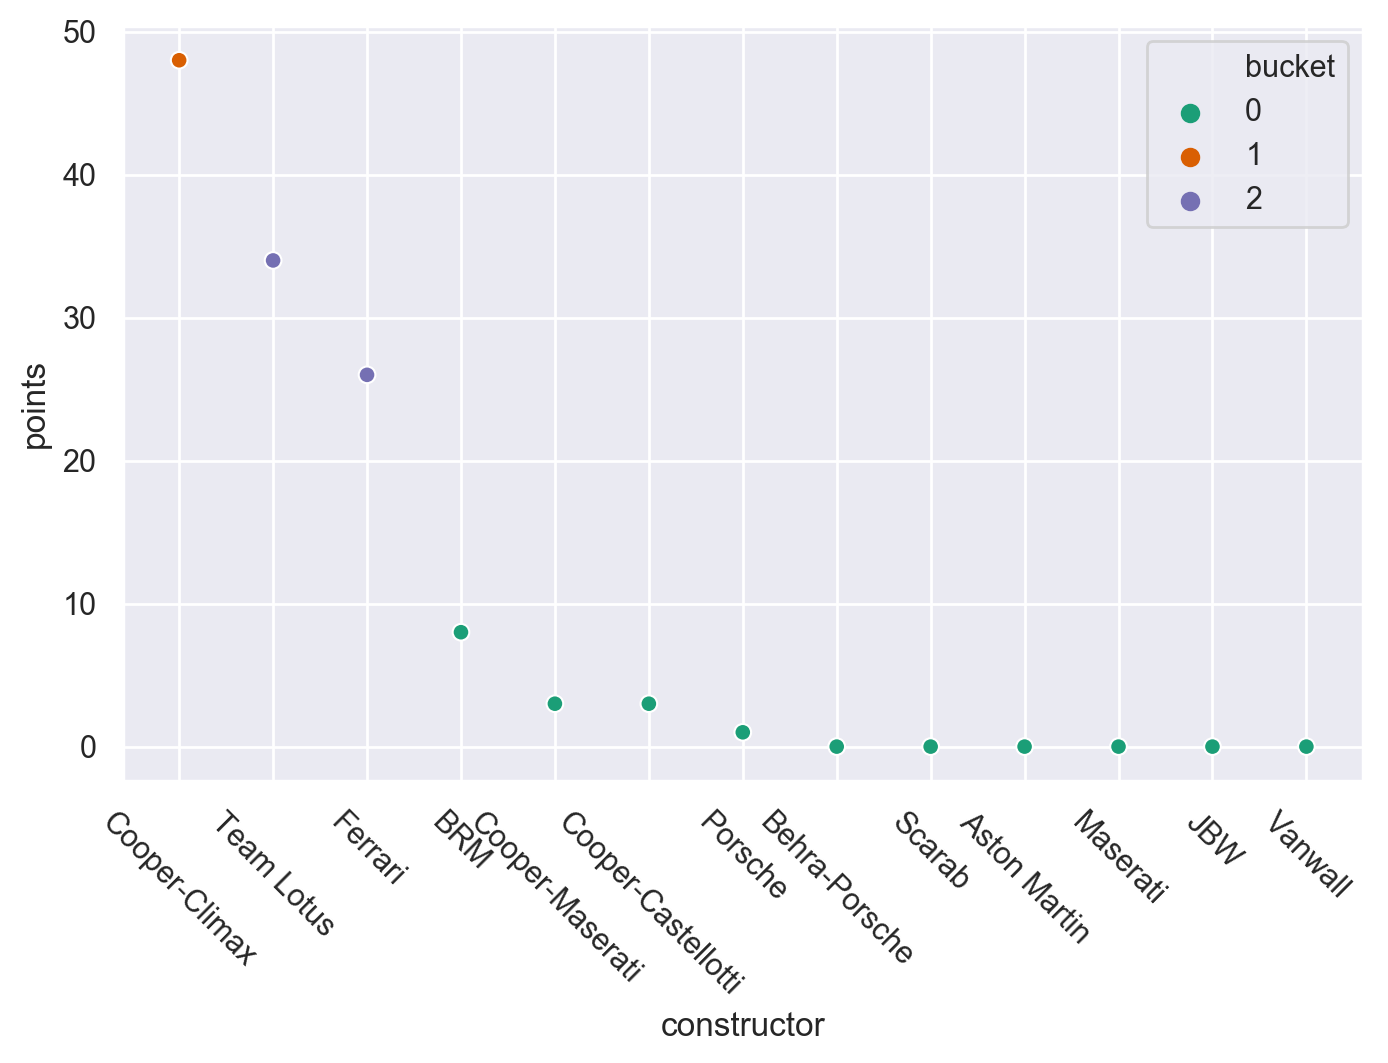

In [10]:
season = 1960

season_races = races[races['year'] == season]
features = constructor_standings[constructor_standings.raceId == season_races.raceId.max()]
features = features[['position', 'points', 'constructorId']]
features['constructor'] = [constructors[constructors.constructorId == x].name.values[0] for x in features['constructorId']]

num_buckets = 3

kmeans = KMeans(n_clusters=num_buckets)
kmeans.fit_predict(features[['position', 'points']])
features['bucket'] = kmeans.labels_
features = features.sort_values(by='position')

plot_large()
sns.scatterplot(x='constructor', y='points', hue='bucket', data=features,
                palette=sns.color_palette('Dark2', num_buckets))
plt.xticks(rotation=-45);

## F1 over the years
We can compare the fastest qualification lap times of Monaco over the years to see how F1 has gotten faster over the past few decades. Monaco was chosen as the circuit has stayed the same over the decades. We also only use the fastest qualification lap time for the year so that differing race lengths do not factor in.

In [11]:
base_url = 'https://en.wikipedia.org/wiki/{}_Monaco_Grand_Prix'
pole_string = '<a href="/wiki/Pole_position" title="Pole position">Pole position</a>'
fastest_time_start = '<tr><th scope="row" style="width:20%;">Time</th><td colspan="3">'
fastest_time_end = '</td></tr>'
reference_str = '<sup id="cite_ref'
save_path = './f1-data/monacoTimes.csv'

monaco_df = pd.DataFrame(columns=['year', 'lapTimeMillis'])

def datetime_to_millis(dt):
    return (dt.minute * 60 * 1000) + (dt.second * 1000) + (dt.microsecond / 1000)

if os.path.exists(save_path):
    print("Using cached Monaco lap times!")
    monaco_df = pd.read_csv(save_path)
else:
    years = range(1955, 2018)
    parser = HTMLParser()
    print("Downloading data...")
    for year in years:
        print(year, end=", ")
        url = base_url.format(year)
        contents = str(urllib.request.urlopen(url).read())
        pole_index = contents.find(pole_string)
        start_index = contents.find(fastest_time_start, pole_index) + len(fastest_time_start) + 2
        end_index = contents.find(fastest_time_end, start_index)
        time = contents[start_index:end_index]

        if 'reference' in time:
            ref_index = contents.find(reference_str, start_index)
            time = contents[start_index:ref_index]

        if '(aggregate)' in time:
            ref_index = contents.find(' (aggregate)', start_index)
            time = contents[start_index:ref_index]

        try:
            timestamp = datetime.strptime(time, "%M:%S.%f")
        except:
            timestamp = datetime.strptime(time, "%M.%S.%f")
        monaco_df = monaco_df.append({'year': year, 'lapTimeMillis': datetime_to_millis(timestamp)}, ignore_index=True)

    print("DONE!")
    monaco_df.to_csv(save_path)

Using cached Monaco lap times!


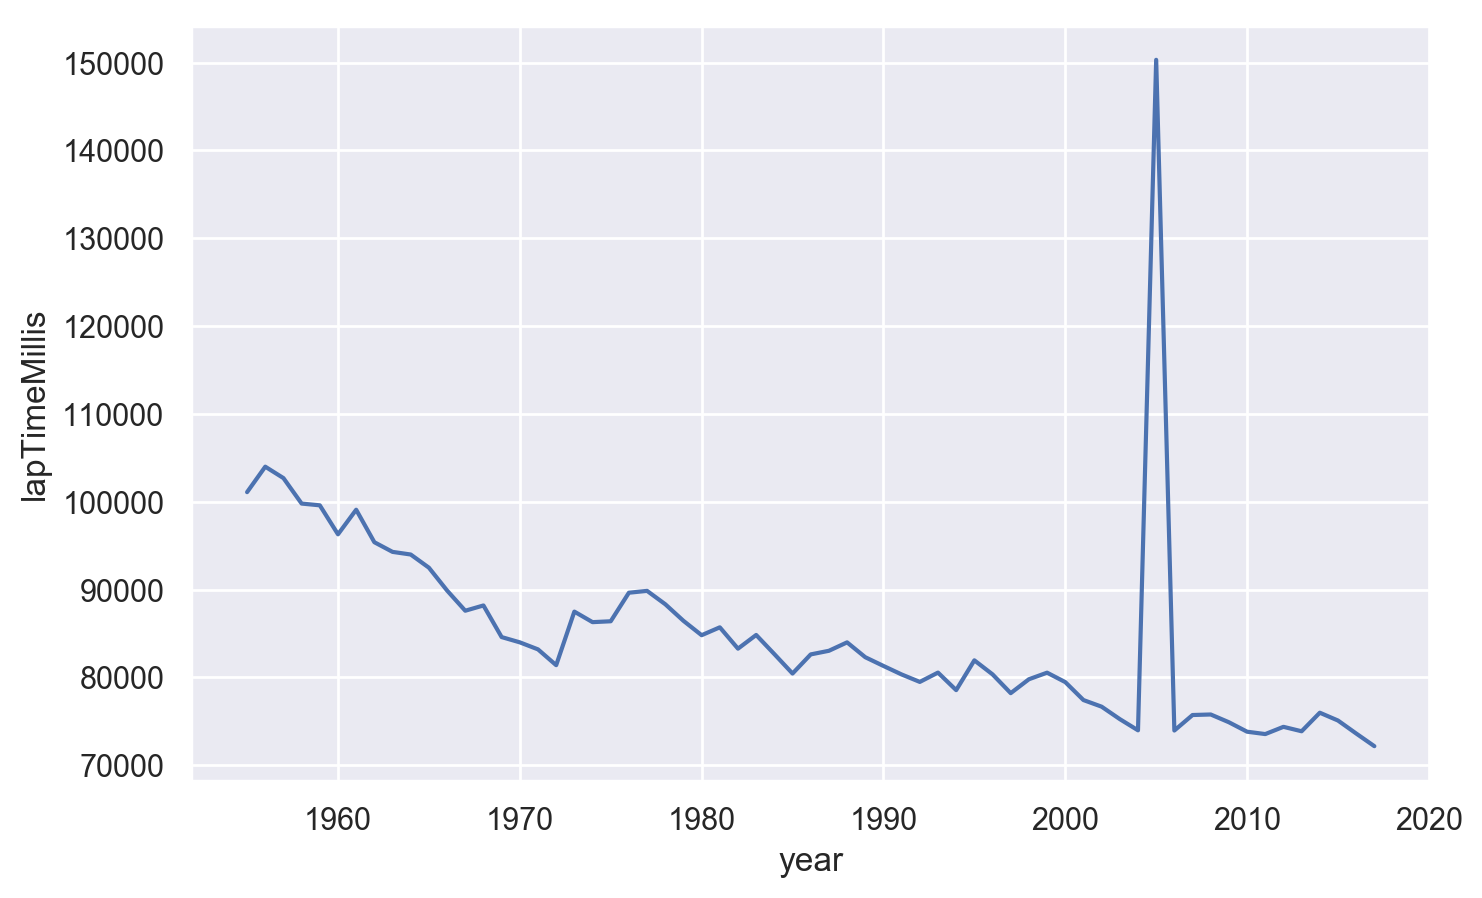

In [12]:
plot_large()
sns.lineplot(x='year', y='lapTimeMillis', data=monaco_df)

The spike in 2005 is because the qualification format was to aggregate 2 laps across 2 days, and in 2005 it was raining on one of the days and hence the aggregate time is abnormally high.

## Circuit difficulty
By getting the percentage of drivers who did not finish a race, we can estimate the difficulty of a circuit.
The cars have gotten safer & more reliable over the years, so circuits which were only used in previous decades may come off as being more difficult than they would be today. Other circuits can also have skewed difficulties. For example, Albert Park is a relatively easy track, but because it's the first race of the year and the teams have new, untested cars, there can be reliability issues leading to retirements. However, on the whole, the graph gives a strong indication of the relative difficulties of the circuits.

Using cached circuit data!


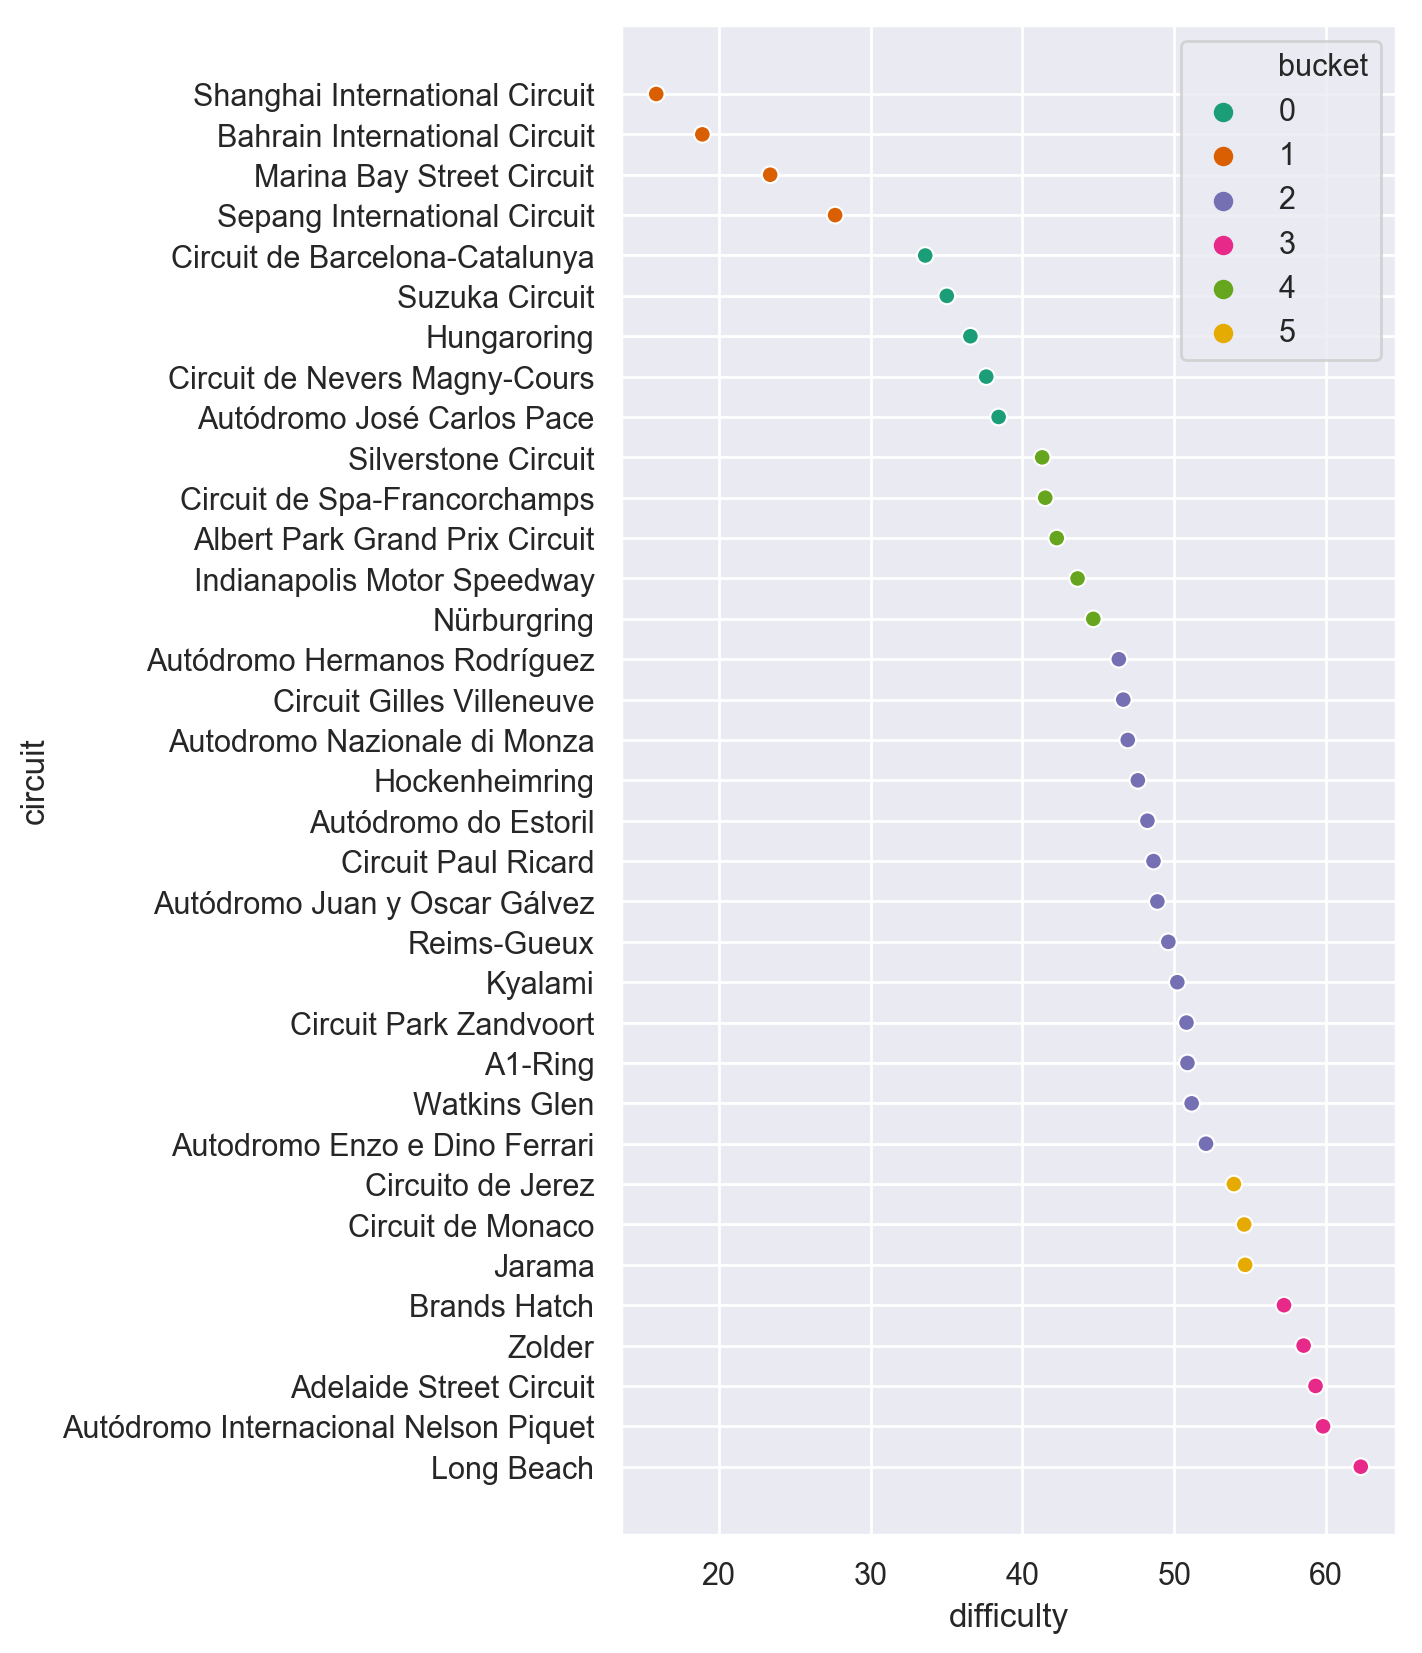

In [13]:
circuits_in_years = races.circuitId.unique()

save_path = './f1-data/circuitsGood.csv'

if os.path.exists(save_path):
    print("Using cached circuit data!")
    circuits_good = pd.read_csv(save_path)
else:
    print("Downloading data...")
    good_data = urllib.request.urlopen('http://ergast.com/api/f1/circuits.json?limit=100').read().decode('utf-8')
    better_data = json.loads(good_data)
    circuits_good = pd.DataFrame(better_data['MRData']['CircuitTable']['Circuits'])
    circuits_good.to_csv(save_path)

circuit_data = {'circuit': [], 'difficulty': []}
for circuitId in circuits_in_years:
    circuit_races = races[races.circuitId == circuitId]
    num_invalid = len(results[(results.raceId.isin(circuit_races.raceId)) & (results.position.isna())])
    total = len(results[(results.raceId.isin(circuit_races.raceId))])
    circuit_ref = circuits[circuits.circuitId == circuitId].circuitRef.values[0]
    circuit_name = circuits_good[circuits_good.circuitId == circuit_ref].circuitName.values[0]
    percent_invalid = num_invalid * 100 / total
    if total > 200:
        circuit_data['circuit'].append(circuit_name)
        circuit_data['difficulty'].append(percent_invalid)

circuit_difficulty_df = pd.DataFrame.from_dict(circuit_data).sort_values(by='difficulty', ascending=False)

num_buckets = 6

clustering_model = sklearn.cluster.SpectralClustering(n_clusters=num_buckets)
clustering_model.fit_predict(circuit_difficulty_df['difficulty'].values.reshape(-1, 1))
circuit_difficulty_df['bucket'] = clustering_model.labels_.astype(str)

plt.figure(figsize=(5, 10), dpi=200)
sns.scatterplot(y='circuit', x='difficulty', hue='bucket', data=circuit_difficulty_df,
                palette=sns.color_palette('Dark2', num_buckets));